In [1]:
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
# import the mapping method
from rasterio.p

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.1-CAPI-1.17.1). Conversions between both will be slow.
  warnings.warn(


In [6]:
# import basin boundaries
hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json')
# create a filter to select only the basin of interest
basin_filter = hcdn_basins['gage'].isin(['09124500','09112500','09132500'])
# apply the filter
example_basins = hcdn_basins[basin_filter]
# check the crs 
print(example_basins.crs)
# write the crs to 32613
example_basins = example_basins.set_crs(32613, allow_override=True)
# check the crs again
print(example_basins.crs)


epsg:4326
EPSG:32613


In [14]:
# Now lets open the mean imagery for snowmelt 

# open the mean snowmelt image
mean_snowmelt = rxr.open_rasterio('../data/snowdata/Snowmelt_Timing_North_America_Mean_2001_2018_V2.tif', masked=True).squeeze()
# reproject the image to the basin crs
mean_snowmelt = mean_snowmelt.rio.reproject(example_basins.crs)


<xarray.DataArray (y: 39101, x: 52441)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 -4.392e+06 -4.392e+06 ... 1.573e+07 1.573e+07
  * y            (y) float64 1.611e+07 1.611e+07 ... 1.106e+06 1.106e+06
    band         int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

09112500
140.11111450195312 140.0007 25.116724014282227
09124500
137.44444274902344 134.62572 26.295608520507812
09132500
125.0 127.26636 24.478588104248047


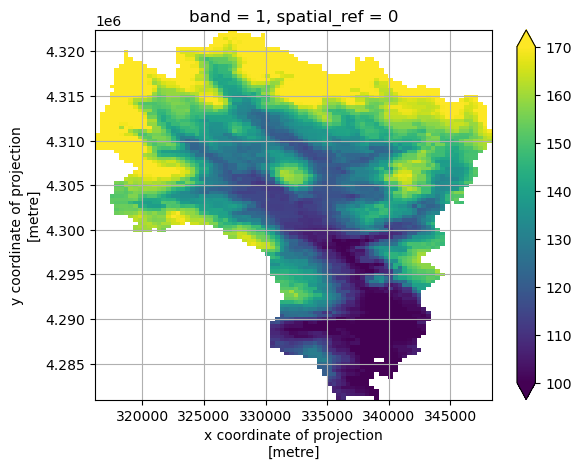

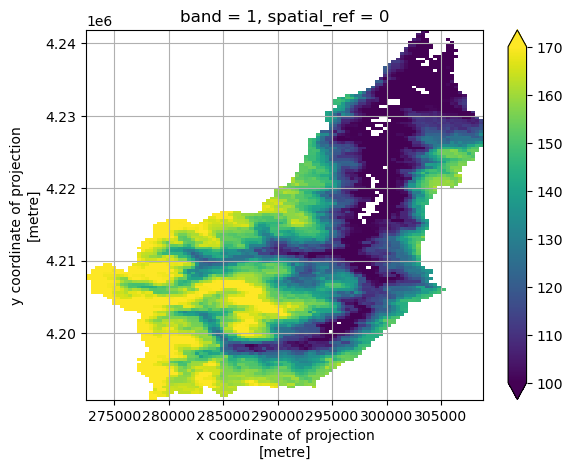

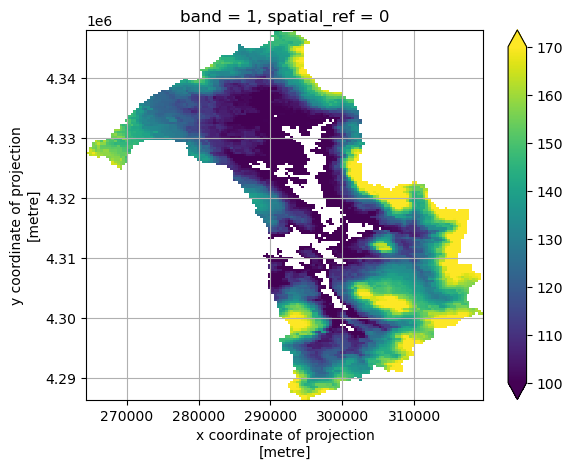

In [30]:
# clip the image to the first basin in example_basins
for site in example_basins['gage']:
    mean_snowmelt_clip = mean_snowmelt.rio.clip(example_basins[example_basins['gage']==site].geometry, example_basins.crs, drop=True)
    # filter values below 100
    mean_snowmelt_clip = mean_snowmelt_clip.where(mean_snowmelt_clip>90)
    # print the mean value
    print(site)
    print(mean_snowmelt_clip.median().values, mean_snowmelt_clip.mean().values, mean_snowmelt_clip.std().values)
    fig, ax = plt.subplots()
    mean_snowmelt_clip.plot(ax=ax,vmin=100, vmax=170)
    ax.grid()

In [ ]:
import xarray as xr


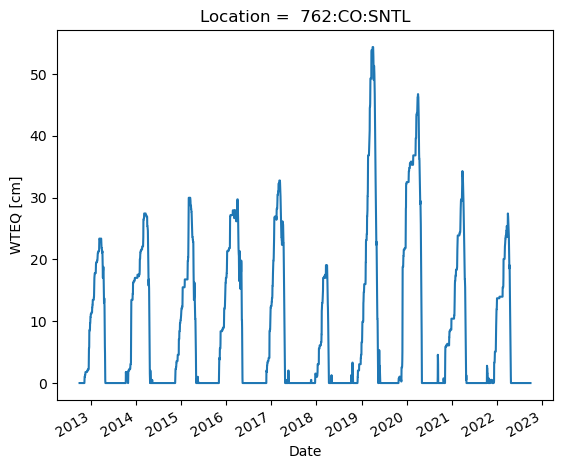

In [65]:
ds.sel(Location=' 762:CO:SNTL')['WTEQ'].plot()

In [67]:

# open ucrb_hcdn_sntl_all_20220930.nc
ds = xr.open_dataset('../data/snowdata/ucrb_hcdn_sntl_all_20220930.nc')
butte_sntl = ds.sel(Location=' 1188:CO:SNTL')['WTEQ']
melt_timing = []
for year in butte_sntl.Date.dt.year.to_pandas().unique():
    tmp = butte_sntl.where(butte_sntl.Date.dt.year==year, drop=True)
    # print the day of year of the first zero value
    melt_timing.append(tmp.idxmin(dim='Date').dt.dayofyear.values)
import pandas as pd
melt_timing


[array(nan),
 array(nan),
 array(nan),
 array(nan),
 array(nan),
 array(nan),
 array(nan),
 array(274),
 array(120),
 array(120),
 array(121),
 array(103),
 array(1),
 array(125),
 array(124),
 array(142),
 array(127),
 array(140),
 array(106),
 array(133),
 array(131),
 array(111),
 array(119),
 array(121),
 array(95),
 array(118),
 array(118),
 array(144),
 array(112),
 array(92),
 array(129),
 array(115),
 array(137),
 array(118),
 array(100),
 array(115),
 array(103),
 array(102),
 array(127),
 array(110),
 array(3),
 array(153),
 array(121),
 array(111),
 array(106)]